# Ok, I have clusters... Now what?

> "The difference between a goat rodeo and making clusters is *using your clusters for deeper insight.*" - Ryan Orsinger

## Clusters are about providing options and insight
- **Step 1:** Explore each cluster. 
    - Look at the relationship of cluster identity to your target variable if you have one (statistical testing, bivariate visualization)
    - Look at the relationship of cluster identity to other variables (statistical testing, trivariate visualizations...think `relplot`)
- **Step 2:** Name your clusters (if it makes sense to do so). Provide a verbal description of your clusters to help stakeholders understand.
---
Additional Uses:

- **Option 1:** Dimensionality reduction. Some features with high degrees of correlation can be combined into clusters. 
- **Option 2:** Treat cluster names as a new target variable. As new data comes in, label that data with your clustering model as the first step of a greater process (customer segmentation, workflow, etc.)
- **Option 3:** Use clustering as the stepping point to developing new questions you wouldn't know to ask until the data was clustered. Perform a deep EDA. 
- **Option 4:** Rather than feed your clusters as a feature of another model, take a "many models" approach and create multiple models that are uniquely tuned to one cluster subset at a time.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from scipy import stats

### Acquire

In [2]:
# csv contains mall data
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/cc276eea59e8295204d1f581c8da509f/raw/2388559aef7a0700eb31e7604351364b16e99653/mall_customers.csv', index_col="customer_id")
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### Prepare
- We are going to make some clusters, and prior exploration revealed that `gender` was not particularly insightful for this process. So we will drop `gender`.

In [3]:
df = df.drop(columns='gender')

For the purposes of the demo, I'm pretending that my df is my train dataset since I have so few observations

In [4]:
train = df

Scale features:

In [5]:
# make the thing
scaler = MinMaxScaler()

# fit the thing on train
scaler.fit(train)

# use the thing (scale train)
train_scaled = scaler.transform(train)

# turn the scaled array into a dataframe
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)

If we also had validate and test datasets, I would have run the following lines of code to scale the data I have in validate and test.

```python
validate_scaled = scaler.transform(validate) 
test_scaled = scaler.transform(test) 
```

And I could turn those arrays into dataframes as well:

```python
validate_scaled = pd.DataFrame(train_scaled, columns=validate.columns) 
test_scaled = pd.DataFrame(train_scaled, columns=test.columns)
```

In [6]:
train_scaled.head()

,age,annual_income,spending_score
customer_id,,,
1,0.019231,0.000000,0.387755
2,0.057692,0.000000,0.816327
3,0.038462,0.008197,0.051020
4,0.096154,0.008197,0.775510
5,0.250000,0.016393,0.397959


We saw 5 clusters in our exploration of the data. Let's visualize an elbow method to see if inertia values supports our hunch that there are 5 clear groups.

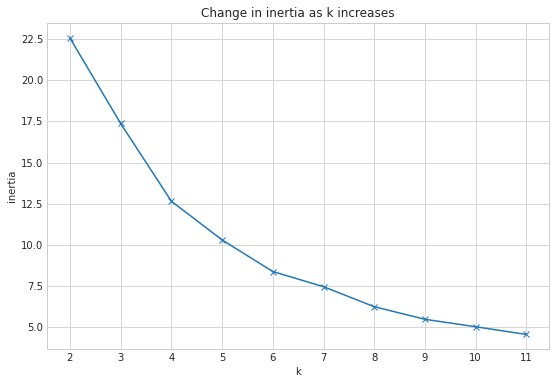

In [7]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=42).fit(train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [8]:
# Let's move forward with k=5
kmeans = KMeans(n_clusters = 5, random_state=42)
kmeans.fit(train_scaled)

# And assign the cluster number to a column on the dataframe
train_scaled["cluster"] = kmeans.predict(train_scaled)
train_scaled.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,0.019231,0.000000,0.387755,2
2,0.057692,0.000000,0.816327,4
3,0.038462,0.008197,0.051020,2
4,0.096154,0.008197,0.775510,4
5,0.250000,0.016393,0.397959,2


In [9]:
train_scaled.cluster.value_counts()

0    58
2    49
1    40
3    30
4    23
Name: cluster, dtype: int64

### So we have clusters. What are our options?
- Step 1: Explore
- Step 2: Name


- Option 1: Simplify variables
- Option 2: Use model and cluster names to classify new observations
- Option 3: Deeper EDA
- Option 4: Take a "many models" approach

### Step 1: Explore each cluster to see how they are similar or different
- Visualizations
- Statistical tests

> "Take the time to get to know each cluster" - Ryan Orsinger

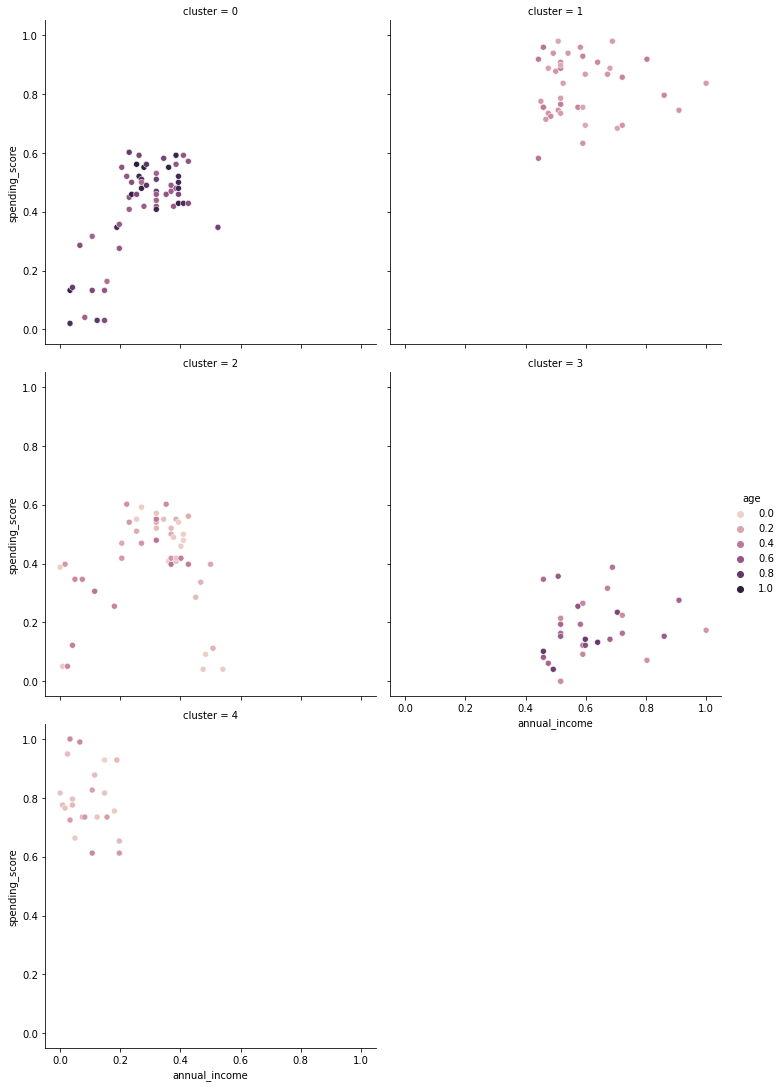

In [11]:
# plot out income vs. spending with regard to the cluster and age
sns.relplot(data=train_scaled, x="annual_income", y="spending_score", col="cluster", hue="age", col_wrap=2)

In [12]:
train_scaled.groupby("cluster").mean()

,age,annual_income,spending_score
cluster,,,
0,0.722149,0.274449,0.416080
1,0.286058,0.582787,0.821684
2,0.174254,0.303111,0.408580
3,0.500000,0.615847,0.172789
4,0.144649,0.092659,0.791482


In [13]:
train_scaled.groupby("cluster").min()

,age,annual_income,spending_score
cluster,,,
0,0.461538,0.032787,0.020408
1,0.173077,0.442623,0.581633
2,0.000000,0.000000,0.040816
3,0.269231,0.459016,0.000000
4,0.000000,0.000000,0.612245


In [14]:
train_scaled.groupby("cluster").max()

,age,annual_income,spending_score
cluster,,,
0,1.000000,0.524590,0.602041
1,0.423077,1.000000,0.979592
2,0.423077,0.540984,0.602041
3,0.788462,1.000000,0.387755
4,0.326923,0.196721,1.000000


In [15]:
train_scaled.groupby("cluster").agg(['mean', 'max', 'min'])

age                     annual_income                      \
             mean       max       min          mean       max       min   
cluster                                                                   
0        0.722149  1.000000  0.461538      0.274449  0.524590  0.032787   
1        0.286058  0.423077  0.173077      0.582787  1.000000  0.442623   
2        0.174254  0.423077  0.000000      0.303111  0.540984  0.000000   
3        0.500000  0.788462  0.269231      0.615847  1.000000  0.459016   
4        0.144649  0.326923  0.000000      0.092659  0.196721  0.000000   

        spending_score                      
                  mean       max       min  
cluster                                     
0             0.416080  0.602041  0.020408  
1             0.821684  0.979592  0.581633  
2             0.408580  0.602041  0.040816  
3             0.172789  0.387755  0.000000  
4             0.791482  1.000000  0.612245

Run a statistical test to answer a question:

$H_0$: There is no difference in spending score between cluster 0 and cluster 2.

$H_a$: There is a difference in spending score between cluster 0 and cluster 2.

In [16]:
#Run the t-test
t_value, p_value2 = stats.ttest_ind(train_scaled[train_scaled['cluster'] == 0].spending_score,
                                    train_scaled[train_scaled['cluster'] == 2].spending_score)

t_value, p_value2

(0.24021994173724392, 0.8106281241255671)

In [17]:
#Test my hypothesis
alpha = 0.05

if p_value2 < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We fail to reject the null hypothesis.


Spending score appears to be the same for these two groups (cluster 0 and cluster 2). 

$H_0$: There is no difference in age between cluster 0 and cluster 2.

$H_a$: There is a difference in age between cluster 0 and cluster 2.

In [18]:
#Run the t-test
t_value, p_value2 = stats.ttest_ind(train_scaled[train_scaled['cluster'] == 0].age,
                                    train_scaled[train_scaled['cluster'] == 2].age)

t_value, p_value2

(18.738317795257696, 2.860710779092233e-35)

In [19]:
#Test my hypothesis
alpha = 0.05

if p_value2 < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


Their spending scores might be the same, but their ages are different. 

We can use this knowledge to help us in the next step.

### Step 2: Name the clusters with descriptive language

In [20]:
train_scaled.cluster = train_scaled.cluster.map({
    0: "general-older",
    1: "target",
    2: "general-younger",
    3: "frugal-high-income",
    4: "spendthrift-young",
})

train_scaled.head()

,age,annual_income,spending_score,cluster
customer_id,,,,
1,0.019231,0.000000,0.387755,general-younger
2,0.057692,0.000000,0.816327,spendthrift-young
3,0.038462,0.008197,0.051020,general-younger
4,0.096154,0.008197,0.775510,spendthrift-young
5,0.250000,0.016393,0.397959,general-younger


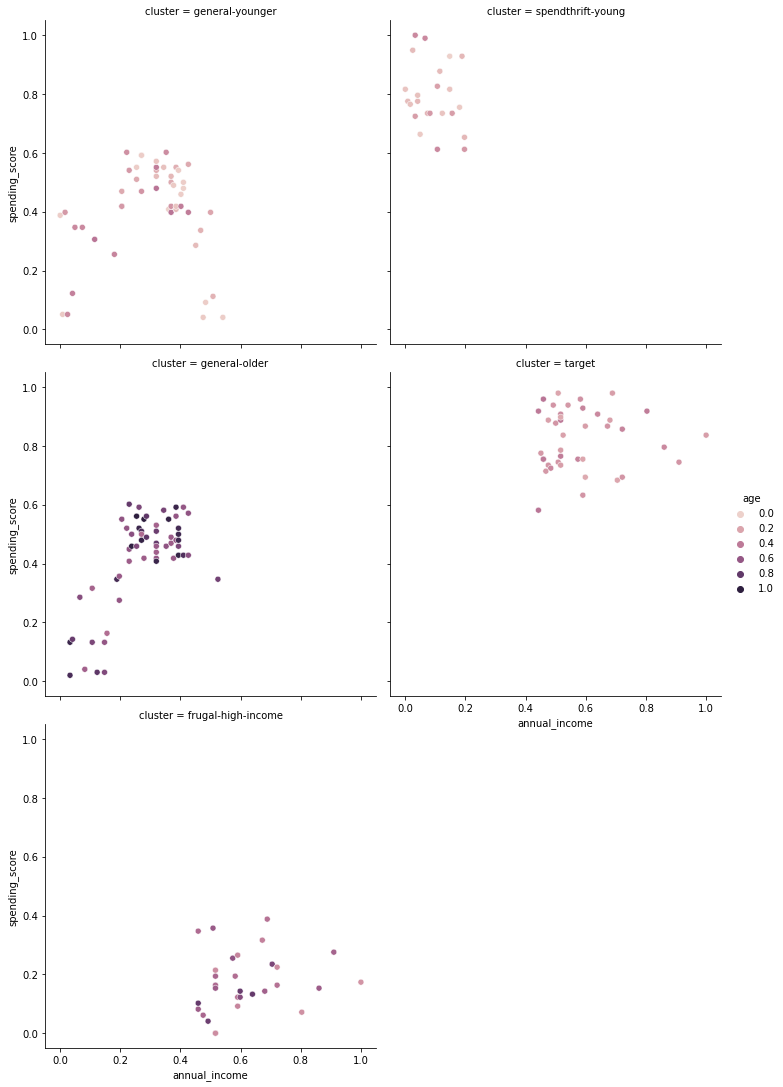

In [21]:
sns.relplot(data=train_scaled, x="annual_income", y="spending_score", col="cluster", hue="age", col_wrap=2)

## Option 1: Use the clusters to simplify multiple other variables (dimensionality reduction)

- Since the cluster names make sense, we can use them instead of age, spending, and income.
- This might be useful to reduce features (called dimensionality reduction)
- Dimensionality reduction might likely help other model performance (regressions, classifications)
- Simplifying our analysis to a handful of English terms can help with our storytelling.
- Business and stakeholders, generally, crave simple answers. Clustering can help you with that.

In [22]:
train_scaled.drop(columns=["age", "annual_income", "spending_score"]).head()

,cluster
customer_id,
1,general-younger
2,spendthrift-young
3,general-younger
4,spendthrift-young
5,general-younger


In [23]:
pd.get_dummies(train_scaled)

,age,annual_income,spending_score,cluster_frugal-high-income,cluster_general-older,cluster_general-younger,cluster_spendthrift-young,cluster_target
customer_id,,,,,,,,
1,0.019231,0.000000,0.387755,0,0,1,0,0
2,0.057692,0.000000,0.816327,0,0,0,1,0
3,0.038462,0.008197,0.051020,0,0,1,0,0
4,0.096154,0.008197,0.775510,0,0,0,1,0
5,0.250000,0.016393,0.397959,0,0,1,0,0
...,...,...,...,...,...,...,...,...
196,0.326923,0.860656,0.795918,0,0,0,0,1
197,0.519231,0.909836,0.275510,1,0,0,0,0
198,0.269231,0.909836,0.744898,0,0,0,0,1


### Option 2: Use cluster names as a target variable to classify new data

Imagine that this dataset had other variables that our company could routinely collect by passive observation (think cookie tracking on websites):

- `transportation`
- `accompanying_individuals`
- `hair_color`
- `wedding_band`

And data that we had to run a special survey to collect (the data that we clustered on):
- `age`
- `annual_income`
- `spending_score`

We added a new column, and we can treat that as a target variable now:
- `cluster`

We could built a **decision tree** model using the features that are easy to collect (`transportation`, `accompanying_individuals`, `hair_color`, `wedding_band`) to predict `cluster`. This could help us identify our target customers as they enter our mall without asking them the survey questions.

### Option 3: Perform deeper EDA

Sometimes the identification of clusters gives us additional questions we need to ask. Simpson's paradox, anyone?

### Option 4: Create a Many Models Approach
- Cluster 0 may have an upward linear trend between income and spending, best modeled by OLS linear regression
- Cluster 1 may have an up then down polynomial trend between income and spending, best modeled by polynomial linear regression
- Cluster 2 may be more random, best modeled by a regression tree

In this way, we can create a machine learning pipeline that sends customers to different prediction models based on their cluster membership.

**Remember:**
- We can dive into each cluster individually w/ exploration
- stats + hypothesis testing
- visualizations for each cluster, comparing/contrasting
